# MIS 583 Assignment 6: Text Sentiment Classification with Prompt Learning

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 陳昱逢, B092040016

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive or negative based on the emotions customers express within them.

In Task 1, you need to fine-tune a pre-trained language model (e.g., BERT) to predict the sentiment of given tweets.

In Task 2, we employ prompts to enable the model to perform sentiment analysis through in-context learning, eliminating the need for additional training.

In Task 3, you will use the method called LM-BFF to utilize the model in generating the optimal template and verbalizer autonomously.


# Notice 
**You are not allow to use the model like GPT family or pre-trained weight using SST-2 and twitter dataset!!!!!!!!!!!!!!!!!**

You can use BERT and RoBERTa encoder model

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
torch 1.12.0a0+8a1a93a
torchvision 0.13.0a0


# Task 1: Text Sentiment Classification (40 points)

In this task, you need to fine-tune a pre-trained language model (e.g., BERT or RoBERTa encoder) to predict the sentiment of given tweets.


## Loading Model and Data

First, let's talk about the model. The Hugging Face team has created an amazing framework called "transformers" for NLP tasks. It includes many state-of-the-art machine learning models for PyTorch, TensorFlow, and JAX.

To start with this package, follow [this link to installation and a basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [3]:
# you might need some additional installations there
!echo happy installation
!pip -V
!pip install grpcio
!pip install google-auth
!pip install protobuf==3.9.2
!pip install pyprind
!pip install tqdm boto3 requests regex sentencepiece sacremoses

happy installation
pip 22.1.2 from /opt/conda/lib/python3.8/site-packages/pip (python 3.8)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 2.3 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wandb 0.16.0 requires protobuf!=4.21.0,<5,>=3.12.0; python_version < "3.9" and sys_platform == "linux", but you have protobuf 3.9.2 which is incompatible.
onnx 1.11.0 requires protobuf>=3.12.2, but you hav

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 213.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from torch import nn

#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

bert_type = 'bert-base-uncased'


# ---------- 1. load from torch.hub ----------
# tokenizer = torch.hub.load(xxx, 'tokennnnnizer', bert_type)

# create a Bert-extended task (classification)
# model = torch.hub.load(xxx, 'modddddddddel', bert_type)

# ---------- 2. load from installed huggingface ----------
tokenizer = BertTokenizer.from_pretrained(bert_type)

# create a Bert-extended task (classification)
model = BertForSequenceClassification.from_pretrained(bert_type)



# finetune from the output from bert to your task
model.classifier = nn.Linear(768, 3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################


roberta_type = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_type)
model = RobertaForSequenceClassification.from_pretrained(roberta_type, num_labels=3)

#mymodel
class CustomRobertaForSequenceClassification(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate):
        super().__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        # Get the output from the pre-trained RoBERTa model
        outputs = self.model.roberta(input_ids=input_ids, attention_mask=attention_mask)

        # Apply dropout to the pooled output
        pooled_output = self.dropout(outputs.last_hidden_state)
        
        # Pass the pooled output to the classification head
        logits = self.model.classifier(pooled_output)

        return logits

# Usage
model_name = 'roberta-large'
num_labels = 3
dropout_rate = 0.5
model = CustomRobertaForSequenceClassification(model_name, num_labels, dropout_rate)


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weight

## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzip Data

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1317** 筆資料.  
Testing set 有 **3075** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
!unzip -qq ./drive/MyDrive/twitter_sentiment.zip

# Loading the dataset

In [3]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []

    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [4]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

## `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [5]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [6]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0]) # converts a sequence of numeric IDs in the training dataset into their corresponding tokens using the specified tokenizer.
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t)) # converts a sequence of tokens (t) back into the original text string using the specified tokenizer.

token ['<s>', '@', 'united', 'ĠI', 'Ġhave', 'Ġnever', 'Ġbeen', 'Ġmislead', 'Ġby', 'Ġa', 'Ġcompany', 'Ġas', 'Ġmany', 'Ġtimes', 'Ġas', 'ĠI', 'Ġhave', 'Ġthis', 'Ġweek', 'Ġby', 'ĠUnited', 'ĠAirlines', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

# Define loss and optimizer

In [7]:
device = torch.device('cuda')

from torch import nn
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Utility Function

In [8]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

# Train function

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. Clean the gradients of optimizer
        # 2. Put correct variables into model
        # 3. Get prediction
        # 4. Evalutate by criterion and accuracy
        optimizer.zero_grad()
        outputs = model(text, attention_mask = mask)
        loss = criterion(outputs, label)#.logits
        acc = accuracy(outputs,label)
        #acc = (outputs.argmax(dim=-1) == label).float().mean()
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. Put correct variables into model
        # 2. Get prediction
        # 3. Evalutate by criterion and accuracy
        outputs = model(text, attention_mask = mask)
        loss = criterion(outputs, label)
        acc = accuracy(outputs,label)
        #acc = (outputs.argmax(dim=-1) == label).float().mean()
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)

    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

# Start Training

In [10]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 15
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################
import math

best_epoch = 0
weights_models = []
best_model_weight = 0

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))
        
    if epoch >= max_epoch - 3:
        model_weight = math.log(val_acc/(1-val_acc)) / 2.0
        weights_models.append(model_weight)

    m.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        best_epoch = epoch
        best_model_weight = math.log(val_acc/(1-val_acc)) / 2.0
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 42/42 [00:04<00:00, 10.12it/s]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch 1 train_loss: 0.009258907632924076 train_acc: 0.7578064012490242
Epoch 1 val_loss:  0.012468344291167202 val_acc : 0.8580106302201974
---------- e 1 save best model ----------


100%|██████████| 42/42 [00:04<00:00, 10.09it/s]


Epoch 2 train_loss: 0.005739351571664784 train_acc: 0.8594847775175644
Epoch 2 val_loss:  0.013142543260768995 val_acc : 0.85041761579347


100%|██████████| 42/42 [00:04<00:00, 10.09it/s]


Epoch 3 train_loss: 0.004485996882085871 train_acc: 0.8951990632318502
Epoch 3 val_loss:  0.012836004195815475 val_acc : 0.853454821564161


100%|██████████| 42/42 [00:04<00:00, 10.15it/s]


Epoch 4 train_loss: 0.003625567634586335 train_acc: 0.919496487119438
Epoch 4 val_loss:  0.01555145753081888 val_acc : 0.8633257403189066
---------- e 4 save best model ----------


100%|██████████| 42/42 [00:04<00:00, 10.12it/s]


Epoch 5 train_loss: 0.0025761367444706545 train_acc: 0.9442818110850898
Epoch 5 val_loss:  0.016383190468892785 val_acc : 0.85041761579347


100%|██████████| 42/42 [00:04<00:00, 10.12it/s]


Epoch 6 train_loss: 0.002000390769774567 train_acc: 0.9593091334894613
Epoch 6 val_loss:  0.019193435036442923 val_acc : 0.8435839028094153


100%|██████████| 42/42 [00:04<00:00, 10.11it/s]


Epoch 7 train_loss: 0.0016894349317625457 train_acc: 0.9656518345042935
Epoch 7 val_loss:  0.019210863014914367 val_acc : 0.8686408504176157
---------- e 7 save best model ----------


100%|██████████| 42/42 [00:04<00:00, 10.10it/s]


Epoch 8 train_loss: 0.001419355063884578 train_acc: 0.9739461358313818
Epoch 8 val_loss:  0.020033811174574236 val_acc : 0.8678815489749431


100%|██████████| 42/42 [00:04<00:00, 10.15it/s]


Epoch 9 train_loss: 0.0011310546963398762 train_acc: 0.9784348165495707
Epoch 9 val_loss:  0.021463000302260633 val_acc : 0.8633257403189066


100%|██████████| 42/42 [00:04<00:00, 10.11it/s]


Epoch 10 train_loss: 0.0009887680481042594 train_acc: 0.9803864168618267
Epoch 10 val_loss:  0.021653110755035752 val_acc : 0.8686408504176157


100%|██████████| 42/42 [00:04<00:00, 10.11it/s]


Epoch 11 train_loss: 0.0010474183907747635 train_acc: 0.9792154566744731
Epoch 11 val_loss:  0.022176309163267946 val_acc : 0.8595292331055429


100%|██████████| 42/42 [00:04<00:00, 10.15it/s]


Epoch 12 train_loss: 0.0007030534373560323 train_acc: 0.9874121779859485
Epoch 12 val_loss:  0.02228027292526905 val_acc : 0.8618071374335611


100%|██████████| 42/42 [00:04<00:00, 10.12it/s]


Epoch 13 train_loss: 0.0006684049403049185 train_acc: 0.9867291178766588
Epoch 13 val_loss:  0.024170019345208803 val_acc : 0.8648443432042521


100%|██████████| 42/42 [00:04<00:00, 10.08it/s]


Epoch 14 train_loss: 0.0012266719060390896 train_acc: 0.9759953161592506
Epoch 14 val_loss:  0.023500574617422998 val_acc : 0.8519362186788155


100%|██████████| 42/42 [00:04<00:00, 10.11it/s]


Epoch 15 train_loss: 0.0007583218533572996 train_acc: 0.9839968774395004
Epoch 15 val_loss:  0.025374560363218755 val_acc : 0.8671222475322703


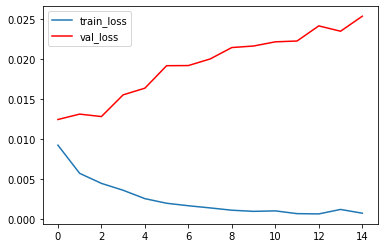

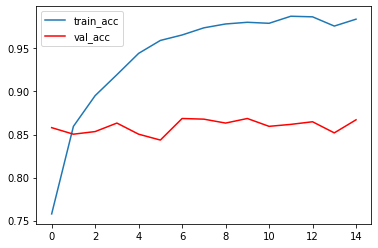

In [11]:
# plot them out
m.plot()

# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/f072e95f51bc48978225941dba218241).


In [12]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 97/97 [00:09<00:00, 10.31it/s]


In [23]:
#ensemble
torch.cuda.empty_cache()
# best_model = CustomRobertaForSequenceClassification('roberta-large', 3, 0.5)
# state_dict = torch.load('ckpts/e7.pt')
# best_model.load_state_dict(state_dict)
# best_model.to(device)
# best_model_weight = 


best_model.eval()

test_data = DataLoader(dataset_test, batch_size=16,
                       shuffle=False)

models_list = list(range(max_epoch-3,max_epoch+1))


total_out = []
for text, mask in test_data:
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    out_list = []
    for i in models_list:
        torch.cuda.empty_cache()
        model = CustomRobertaForSequenceClassification('roberta-large', 3, 0.5)
        state_dict = torch.load(f'ckpts/e{i}.pt')
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        out = model(text, mask)
        out_list.append(out)

    pred = output * best_model_weight
    #print("out_list",out_list)
    for i,j in enumerate(out_list):
        pred +=  j * weights_models[i] # no add 

    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred_ensemble.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN

# Task 2: In-Context learning (32 points)

In this task, you will learn how to perform sentiment classification using **prompts** without the need for training.

In [10]:
import torch
import pyprind
import numpy as np
import pandas as pd
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading model and setup

In [27]:
#########################################################################
#         TODO: Design your own template(prefix) and verbalizer         #
#########################################################################
class Config:
    def __init__(self):
        self.template = [
                         'It is [MASK].',
                         'The sentiment of this sentence is [MASK].',
                         'How do you feel after reading this sentence? I feel [MASK].'   # change
                        ]
        self.one_shot = [
                         'I gave you one more try. Figured you could get a 1 hr flight right. Nope. Delayed an hr. Seems to be every time. It is negative.',
                         'I gave you one more try. Figured you could get a 1 hr flight right. Nope. Delayed an hr. Seems to be every time. The sentiment of this sentence is negative.',
                         'I gave you one more try. Figured you could get a 1 hr flight right. Nope. Delayed an hr. Seems to be every time. How do you feel after reading this sentence? I feel negative.'
                        ]
        self.few_shot = [
                         'i will never fly with you again. i went on vacation this week and you lost my bags both ways. now i have no clothes. thankyou. It is negative. Will flights be leaving Dallas for LA on February 24th? It is neutral. Thank you! Off to LA to do something very special. It is positive.',
                         'i will never fly with you again. i went on vacation this week and you lost my bags both ways. now i have no clothes. thankyou. The sentiment of this sentence is negative. Will flights be leaving Dallas for LA on February 24th? The sentiment of this sentence is neutral. Thank you! Off to LA to do something very special. The sentiment of this sentence is positive.',
                         'i will never fly with you again. i went on vacation this week and you lost my bags both ways. now i have no clothes. thankyou. How do you feel after reading this sentence? I feel negative. Will flights be leaving Dallas for LA on February 24th? How do you feel after reading this sentence? I feel neutral. Thank you! Off to LA to do something very special. How do you feel after reading this sentence? I feel positive.'
                        ]
        self.prefix = self.template[2] + self.few_shot[2]  # you can modify this line
        self.verbalizer = {
            #'good': 1,
            'negative': 0,
            'neutral': 1,
            'positive': 2,
            #'terrible':0,
            #'okay':1,
            #'great':2
            
        }
        
        self.max_seq_length = 512
        self.batch_size = 64


config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_type = 'bert-base-uncased'

model = BertForMaskedLM.from_pretrained(bert_type, num_labels = 3)

tokenizer = BertTokenizer.from_pretrained(bert_type)

bert_config = BertConfig.from_pretrained(bert_type)

bert = model.from_pretrained(bert_type, config=bert_config).to(device)
# roberta_type = 'roberta-base'

# model = RobertaForMaskedLM.from_pretrained(roberta_type, num_labels=3)

# tokenizer = RobertaTokenizer.from_pretrained(roberta_type)

# roberta_config = RobertaConfig.from_pretrained(roberta_type)

# model = model.from_pretrained(roberta_type, config=roberta_config).to(device)

#######################################################################
#                        End of your code                             #
#######################################################################

softmax = nn.Softmax(dim=1)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

## Obtaion verbalizer ids

In [28]:
# Utility function to obtaion verbalizer ids
def obtain_verbalizer_ids(verbalizer, tokenizer):
    verbalizer_ids = tokenizer.convert_tokens_to_ids(list(verbalizer.keys()))
    index2ids = {i: verbalizer_ids[i] for i in range(len(verbalizer_ids))}
    return verbalizer_ids, index2ids


In [29]:
verbalizer_ids, index2ids = obtain_verbalizer_ids(config.verbalizer, tokenizer)

## Concatenate original text and prefix

In [30]:
# Utility function to concatenate prefix and text
def concatenate_prefix(texts, config):
    ##################################################
    #   TODO: concatenate your own prefix and text   #                               
    ##################################################
    #prefix_texts = []
    prefix_texts = [config.prefix + " " + text for text in texts]
    ##################################################
    #                 End of your code               #                               
    ##################################################
    return prefix_texts

In [31]:
def load_data(config):
    # ['texts', 'labels']
    df = pd.read_csv('./twitter_sentiment/train.csv')
    original_texts = df['text'].tolist()
    labels = df['sentiment_label'].tolist()

    texts = concatenate_prefix(original_texts, config)

    return texts, labels


texts, labels = load_data(config)

In [32]:
# Batching of texts and labels for training or processing in batches
def pack_batch(texts, labels, batch_size):
    """
    :param texts: list
    :param labels: list
    :param batch_size: int
    :return batch_X: list
            [[text11, text12, ...], [text21, text22, ...], ...]
    :return batch_y: list
            [[label11, label12, ...], [label21, label22, ...], ...]
    :return batch_count: int
    """
    assert len(texts) == len(labels)

    if len(texts) % batch_size != 0:
        flag = False
        batch_count = int(len(texts) / batch_size) + 1
    else:
        flag = True
        batch_count = int(len(texts) / batch_size)

    batch_X, batch_y = [], []

    if flag:
        for i in range(batch_count):
            batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
            batch_y.append(labels[i * batch_size: (i + 1) * batch_size])
    else:
        for i in range(batch_count):
            if i == batch_count - 1:
                batch_X.append(texts[i * batch_size:])
                batch_y.append(labels[i * batch_size:])
            else:
                batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
                batch_y.append(labels[i * batch_size: (i + 1) * batch_size])

    return batch_X, batch_y, batch_count

In [33]:
batch_X, batch_y, batch_count = pack_batch(texts, labels, config.batch_size)

## Inferencing the model without training

In [34]:
with torch.no_grad():
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    pper = pyprind.ProgPercent(batch_count)
    for i in range(batch_count):
        inputs = batch_X[i]
        labels = batch_y[i]

        # Using the BERT tokenizer (tokenizer.batch_encode_plus), adding special tokens, ensuring a maximum sequence length, and handling padding/truncation
        tokens = tokenizer.batch_encode_plus(inputs, add_special_tokens=True,
                                             max_length=config.max_seq_length,
                                             padding='max_length', truncation=True)
        
        ids = torch.tensor(tokens['input_ids']).to(device)
        attention_mask = torch.tensor(tokens['attention_mask']).to(device)

        # Shape: (batch_size, max_seq_length, vocab_size)
        logits = bert(ids, attention_mask=attention_mask).logits

        mask_token_index = (ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        # Find [MASK] logits
        # shape: (batch_size, vocab_size)
        masked_logits = logits[mask_token_index[0], mask_token_index[1], :]

        # Extract the logits of the word in the verbalizer at the [MASK] position
        # shape: (batch_size, verbalizer_size)
        verbalizer_logits = masked_logits[:, verbalizer_ids]

        # Construct a pseudo-distribution from the logits in these verbalizers
        pseudo_distribution = softmax(verbalizer_logits)

        #################################################################################
        #   1. Find the index with the maximum probability in the pseudo-distribution   #
        #   2. Convert the index to the corresponding word ID                           #
        #   3. Convert the ID to a token                                                #
        #   4. Find the label corresponding to the token                                #                                                                           
        #################################################################################

        pred_indices = torch.argmax(pseudo_distribution, dim=1)

        pred_ids = [verbalizer_ids[index] for index in pred_indices]

        pred_tokens = [tokenizer.convert_ids_to_tokens(id) for id in pred_ids]

        pred_labels = [config.verbalizer[token] for token in pred_tokens]

        #################################################################################
        #                             End of your code                                  #                                       
        #################################################################################

        predict_all = np.append(predict_all, pred_labels)
        labels_all = np.append(labels_all, labels)

        pper.update()

    acc = accuracy_score(labels_all, predict_all)
    p = precision_score(labels_all, predict_all, average="weighted")
    r = recall_score(labels_all, predict_all, average="weighted")
    f1 = f1_score(labels_all, predict_all, average="weighted")

    print('accuracy: %f | precision: %f | recall: %f | f1: %f' % (acc, p, r, f1))

accuracy: 0.319770 | precision: 0.611507 | recall: 0.319770 | f1: 0.303800


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Task 3: LM-BFF (45 points)

https://arxiv.org/pdf/2012.15723.pdf

Unlike the previous task, LM-BFF can generate templates and verbalizers automatically.

# Get Data

請先到共用雲端硬碟將檔案 `SST-2.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14MDYFasXU94dUE9DjgfcZE61iTRI2007/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

# Install openprompt

This library provides a standard, flexible and extensible framework to deploy the prompt-learning pipeline.

[OpenPrompt Documentation](https://thunlp.github.io/OpenPrompt/)

In [41]:
!pip install openprompt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 235.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 225.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 285.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 189.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 183.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 257.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 305.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 176.9 MB/s eta 0:00:00
     ━━━━━━━


[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


# Import openprompt package

In [10]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

/home/u5536645/.local/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


# Setup cuda and whether to perform automatic generation

In [11]:
cuda = True
auto_t = True # Whether to perform automatic template generation
auto_v = True # Whether to perform automatic verbalizer generation

# Load dataset and model

In [12]:
from openprompt.data_utils.text_classification_dataset import SST2Processor
dataset = {}
dataset['train'] = SST2Processor().get_train_examples("./SST-2/") # i add “.”
dataset['validation'] = SST2Processor().get_dev_examples("./SST-2/")
dataset['test'] = SST2Processor().get_test_examples("./SST-2/")

In [13]:
#print('load model...')
from openprompt.plms import load_plm

# load mlm model for main tasks
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "roberta-large")

# load generation model for template generation
template_generate_model, template_generate_tokenizer, template_generate_model_config, template_tokenizer_wrapper = load_plm('t5', 't5-large')

from openprompt.prompts import ManualVerbalizer, ManualTemplate

# if you wish to do automatic label word generation, the verbalizer is not the final verbalizer, and is only used for template generation.
verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']]) # Manually generate the verbalizer


###################################################################################################################
#   TODO: You need to switch LMBFFTemplateGenerationTemplate or ManualTemplate to                                 #
#         compare auto generate template and manual generate template                                             #
###################################################################################################################
from openprompt.prompts.prompt_generator import LMBFFTemplateGenerationTemplate

############################################
#   LMBFFTemplateGenerationTemplate        #
############################################
import random

# number of demonstrations
num_demonstrations = 8  # try different number

demonstrations = []

for _ in range(num_demonstrations):
    # random choice training set example with label 0 
    random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

    # random choice training set example with label 1
    random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])
    
    demonstration = f'{random_example_1.text_a} It was terrible. {random_example_2.text_a} It was great.'
    demonstrations.append(demonstration)

# You can modify the demonstrations and try different combinations
#'{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.'
demonstrations = [f'{{"text": "{demonstration}", "shortenable_ids": 1}}' for demonstration in demonstrations]
template_text = '{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.' + ' '.join(demonstrations)
template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)

#############################################
#   End of LMBFFTemplateGenerationTemplate  #
#############################################

########################################
#          ManualTemplate              #
########################################

#template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} How do you feel after reading this sentence? I feel {"mask"}.')

########################################
#          End of ManualTemplate       # 
########################################

###################################################################################################################
#                                           End of your code                                                      #
###################################################################################################################


# view wrapped example
wrapped_example = template.wrap_one_example(dataset['train'][0])
print("dataset:", dataset['train'][0])


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/home/u5536645/.local/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please

dataset: {
  "guid": "train-0",
  "label": 0,
  "meta": {
    "labelword": "terrible"
  },
  "text_a": "nothing happens , and it happens to flat characters .",
  "text_b": "",
  "tgt_text": null
}



# Utility Function

In [14]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

# Returns the best evaluation score achieved during training
def fit(model, train_dataloader, val_dataloader, loss_func, optimizer):
    best_score = 0.0
    for epoch in range(5):
        train_loss = train_epoch(model, train_dataloader, loss_func, optimizer)
        score = evaluate(model, val_dataloader)
        if score > best_score:
            best_score = score
        print(f"Epoch {epoch+1}: Train loss={train_loss}, Eval score={score}")
    return best_score

# Trains the model on the training data and computes the training loss
def train_epoch(model, train_dataloader, loss_func, optimizer):
    model.train()
    loss_all = []
    for step, inputs in enumerate(train_dataloader):
        if cuda:
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}  # i change this
        #####################################################
        # 1. Put correct variables into model to get logits #
        # 2. Get labels                                     #
        # 3. Evalutate using loss_func                         #          
        # 4. Append loss to loss_all                        #
        #####################################################
        logits = model(inputs) #.logits  ## unpack
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        loss_all.append(loss.item())
        #####################################################
        #                 End of your code                  #
        #####################################################
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(loss_all)

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if cuda:
                inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()} # i change this
            #####################################################
            # 1. Put correct variables into model to get logits #
            # 2. Get labels                                     #
            # 3. Extend labels to list                          #
            # 4. Get predictions and extend preds to list        #
            #####################################################
            logits = model(inputs)#.logits  ## unpack
            labels = inputs['label']
            alllabels.extend(labels.cpu().numpy())
            allpreds.extend(torch.argmax(logits,dim=1).cpu().numpy())
            #####################################################
            #                 End of your code                  #
            #####################################################
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

# Automatic template generation

Generated template from TemplateGenerator and find the best template 

In [15]:
from tqdm import tqdm

class ManualTemplateWithoutParse(ManualTemplate):
    """The generated template from TemplateGenerator is a list of dict of parsed template_text. So no further parsing is needed."""
    def on_text_set(self):
        pass

# Template generation
if auto_t:
    print('performing auto_t...')

    if cuda:
        template_generate_model = template_generate_model.cuda()

    # Creates an instance of T5TemplateGenerator, used for generating text templates
    template_generator = T5TemplateGenerator(template_generate_model, template_generate_tokenizer, template_tokenizer_wrapper, verbalizer, beam_width=8) # Beam_width is set to 5 here for efficiency; to improve performance, try a larger number.


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=template_generate_tokenizer, tokenizer_wrapper_class=template_tokenizer_wrapper, batch_size=len(dataset['train']), decoder_max_length=2048, max_seq_length=2048, shuffle=False, teacher_forcing=False) #128 seq_length# Register all data at once
    for data in dataloader:
        if cuda:
            data = data.cuda()
        template_generator._register_buffer(data)

    template_generate_model.eval()
    print('generating...')
    template_texts = template_generator._get_templates() # Calls _get_templates on template_generator to generate template texts.

    # Converting and Printing Templates
    original_template = template.text
    template_texts = [template_generator.convert_template(template_text, original_template) for template_text in template_texts] 
    # template_generator._show_template()
    template_generator.release_memory()
    # Generate a number of candidate template text
    print(template_texts)
    
    # Iterate over each candidate and select the best one
    best_metrics = 0.0
    best_template_text = None
    for template_text in tqdm(template_texts):
        verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
        template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
        print(f"current template: {template_text}, wrapped example: {template.wrap_one_example(dataset['train'][0])}")

        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)
        
        #######################################################
        # TODO: Use score to Find your best template_text     #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_template_text = template_text
        #######################################################
        #                 End of your code                    #
        #######################################################
    # Use the best template
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=[['terrible'],['great']])
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
    print("final best template:", best_template_text)
    print("wrapped example:", template.wrap_one_example(dataset["train"][0]))

performing auto_t...


tokenizing: 32it [00:00, 393.74it/s]


generating...


100%|██████████| 18/18 [15:36<00:00, 52.01s/it]


['{"placeholder": "text_a"} It was {"mask"} . sweet and memorable film.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children \'s television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone \'\' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n\'t mean it \'s good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and metaphor . It was great. so we got ten little indians meets frida


  0%|          | 0/8 [00:00<?, ?it/s]

current template: {"placeholder": "text_a"} It was {"mask"} . sweet and memorable film.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and metaphor . It was great. so we got ten little indians 


tokenizing: 32it [00:00, 416.18it/s]

tokenizing: 32it [00:00, 404.04it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.9579511868942046, Eval score=0.5625
Epoch 2: Train loss=0.543757726525655, Eval score=0.71875
Epoch 3: Train loss=0.37852249591742293, Eval score=0.75
Epoch 4: Train loss=0.007963262689372641, Eval score=0.75



 12%|█▎        | 1/8 [00:34<04:03, 34.82s/it]

Epoch 5: Train loss=0.008257244903234096, Eval score=0.8125
current template: {"placeholder": "text_a"} It was {"mask"} ..a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and metaphor . It was g


tokenizing: 32it [00:00, 445.29it/s]

tokenizing: 32it [00:00, 446.58it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=0.5344736354505564, Eval score=0.90625
Epoch 2: Train loss=0.45792340688805666, Eval score=0.9375
Epoch 3: Train loss=0.001265222334033922, Eval score=0.84375
Epoch 4: Train loss=0.18383184290973964, Eval score=0.59375



 25%|██▌       | 2/8 [01:10<03:30, 35.10s/it]

Epoch 5: Train loss=0.6399856068581133, Eval score=0.71875
current template: {"placeholder": "text_a"} It was {"mask"} . as lively an account as seinfeld is deadpan.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a 


tokenizing: 32it [00:00, 465.86it/s]

tokenizing: 32it [00:00, 464.04it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.47412320955749, Eval score=0.53125
Epoch 2: Train loss=0.696895704139024, Eval score=0.84375
Epoch 3: Train loss=0.8868827147662586, Eval score=0.5
Epoch 4: Train loss=0.6587901953607798, Eval score=0.75



 38%|███▊      | 3/8 [01:44<02:54, 34.86s/it]

Epoch 5: Train loss=0.053645331325242296, Eval score=0.875
current template: {"placeholder": "text_a"} It was {"mask"} . it was terrible.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and meta


tokenizing: 32it [00:00, 466.34it/s]

tokenizing: 32it [00:00, 463.29it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.3264856103196507, Eval score=0.5
Epoch 2: Train loss=0.8450061504263431, Eval score=0.625
Epoch 3: Train loss=0.206752780766692, Eval score=0.8125
Epoch 4: Train loss=0.0023497791185036476, Eval score=0.75



 50%|█████     | 4/8 [02:19<02:18, 34.71s/it]

Epoch 5: Train loss=0.534879292538335, Eval score=0.6875
current template: {"placeholder": "text_a"} It was {"mask"} . but it would be better to wait for the video.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a p


tokenizing: 32it [00:00, 434.74it/s]

tokenizing: 32it [00:00, 465.94it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.5301813921675347, Eval score=0.5
Epoch 2: Train loss=0.8364696553908288, Eval score=0.5
Epoch 3: Train loss=0.7239947794005275, Eval score=0.5
Epoch 4: Train loss=0.9580610869452357, Eval score=0.5



 62%|██████▎   | 5/8 [02:53<01:43, 34.66s/it]

Epoch 5: Train loss=0.7430502555798739, Eval score=0.5
current template: {"placeholder": "text_a"} It was {"mask"} . so we got.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and metaphor . It 


tokenizing: 32it [00:00, 433.87it/s]

tokenizing: 32it [00:00, 440.29it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.2171629895583465, Eval score=0.90625
Epoch 2: Train loss=0.42113461900589755, Eval score=0.90625
Epoch 3: Train loss=0.20121321961906347, Eval score=0.90625
Epoch 4: Train loss=0.37694611836735703, Eval score=0.75



 75%|███████▌  | 6/8 [03:28<01:09, 34.85s/it]

Epoch 5: Train loss=0.22646118448056995, Eval score=0.75
current template: {"placeholder": "text_a"} It was {"mask"} . it was terrible. sweet and memorable film.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem


tokenizing: 32it [00:00, 461.42it/s]

tokenizing: 32it [00:00, 441.58it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.814482940324524, Eval score=0.65625
Epoch 2: Train loss=0.5683127023512498, Eval score=0.71875
Epoch 3: Train loss=0.3991101047849952, Eval score=0.6875
Epoch 4: Train loss=0.5486276366687548, Eval score=0.53125



 88%|████████▊ | 7/8 [04:04<00:34, 34.96s/it]

Epoch 5: Train loss=0.9466607405338436, Eval score=0.5
current template: {"placeholder": "text_a"} It was {"mask"} . but it would be better to wait for the movie.a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poe


tokenizing: 32it [00:00, 460.97it/s]

tokenizing: 32it [00:00, 455.97it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.6369478172418894, Eval score=0.5
Epoch 2: Train loss=0.9060643324628472, Eval score=0.5
Epoch 3: Train loss=0.6916195708326995, Eval score=0.53125
Epoch 4: Train loss=0.18616077712613333, Eval score=0.9375


100%|██████████| 8/8 [04:38<00:00, 34.84s/it]

Epoch 5: Train loss=0.4412358758463597, Eval score=0.84375
final best template: {"placeholder": "text_a"} It was {"mask"} ..a rude black comedy about the catalytic effect a holy fool has upon those around him in the cutthroat world of children 's television . It was terrible. a crisp psychological drama (and) a fascinating little thriller that would have been perfect for an old `` twilight zone '' episode . It was great. as lively an account as seinfeld is deadpan . It was terrible. sweet and memorable film . It was great. just a collection of this and that -- whatever fills time -- with no unified whole . It was terrible. the film jolts the laughs from the audience -- as if by cattle prod . It was great. just because a walk to remember is shrewd enough to activate girlish tear ducts does n't mean it 's good enough for our girls . It was terrible. (ramsay) visually transforms the dreary expanse of dead-end distaste the characters inhabit into a poem of art , music and metaphor . It was

# Automatic erbalizer generation

Verbalizer template from VerbalizerGenerator and find the best verbalizer

In [16]:
# Verbalizer generation
from openprompt.prompts.prompt_generator import RobertaVerbalizerGenerator
if auto_v:
    print('performing auto_v...')
    # Load generation model for verbalizer generation
    if cuda:
        plm = plm.cuda()

    # Creates an instance of RobertaVerbalizerGenerator, used for generating verbalizer.
    verbalizer_generator = RobertaVerbalizerGenerator(model=plm, tokenizer=tokenizer, candidate_num=20, label_word_num_per_class=20) # To improve performance, try larger numbers
    

    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, batch_size=32)
    for data in dataloader:
        if cuda:
            data = data.cuda()
        verbalizer_generator.register_buffer(data)

    # Calls generate on verbalizer_generator to generate label words.
    label_words_list = verbalizer_generator.generate()
    verbalizer_generator.release_memory()

    # Iterate over each candidate and select the best one
    current_verbalizer = copy.deepcopy(verbalizer)
    best_metrics = 0.0
    best_label_words = None
    for label_words in tqdm(label_words_list):
        current_verbalizer.label_words = label_words
        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, current_verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to find your best_label_word        #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_label_words = label_words
        #######################################################
        #                 End of your code                    #
        #######################################################
    # use the best verbalizer
    print("final best label words:", best_label_words)
    verbalizer = ManualVerbalizer(tokenizer, num_classes=2, label_words=best_label_words)

performing auto_v...


tokenizing: 32it [00:00, 427.56it/s]
  0%|          | 0/20 [00:00<?, ?it/s]
tokenizing: 32it [00:00, 435.36it/s]

tokenizing: 32it [00:00, 463.56it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3434514319215012, Eval score=0.5
Epoch 2: Train loss=1.4813063474366572, Eval score=0.5
Epoch 3: Train loss=1.038469790830277, Eval score=0.5
Epoch 4: Train loss=0.7289319457486272, Eval score=0.5



  5%|▌         | 1/20 [00:34<10:55, 34.52s/it]

Epoch 5: Train loss=0.7664606682956219, Eval score=0.5



tokenizing: 32it [00:00, 463.84it/s]

tokenizing: 32it [00:00, 467.08it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.5173930872090295, Eval score=0.5
Epoch 2: Train loss=0.9750675549730659, Eval score=0.5
Epoch 3: Train loss=0.7146661973383743, Eval score=0.75
Epoch 4: Train loss=0.7276091433886904, Eval score=0.6875



 10%|█         | 2/20 [01:09<10:21, 34.55s/it]

Epoch 5: Train loss=0.07628067790637516, Eval score=0.71875



tokenizing: 32it [00:00, 429.99it/s]

tokenizing: 32it [00:00, 461.74it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.213880138820968, Eval score=0.5
Epoch 2: Train loss=0.46553625928936526, Eval score=0.90625
Epoch 3: Train loss=0.11389563251395884, Eval score=0.53125
Epoch 4: Train loss=0.5187055578444415, Eval score=0.78125



 15%|█▌        | 3/20 [01:43<09:47, 34.58s/it]

Epoch 5: Train loss=0.0936825139647226, Eval score=0.90625



tokenizing: 32it [00:00, 431.47it/s]

tokenizing: 32it [00:00, 446.14it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.730791650021274, Eval score=0.71875
Epoch 2: Train loss=0.27907343095648685, Eval score=0.84375
Epoch 3: Train loss=0.09673937604566163, Eval score=0.90625
Epoch 4: Train loss=0.13021016963656962, Eval score=0.71875



 20%|██        | 4/20 [02:18<09:16, 34.76s/it]

Epoch 5: Train loss=0.6628700511170891, Eval score=0.71875



tokenizing: 32it [00:00, 429.56it/s]

tokenizing: 32it [00:00, 454.85it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.413888536494376, Eval score=0.5
Epoch 2: Train loss=0.6302612670551753, Eval score=0.71875
Epoch 3: Train loss=0.3570966702682199, Eval score=1.0
Epoch 4: Train loss=0.6057096654499219, Eval score=0.5



 25%|██▌       | 5/20 [02:53<08:43, 34.93s/it]

Epoch 5: Train loss=0.5811967192657903, Eval score=0.8125



tokenizing: 32it [00:00, 445.26it/s]

tokenizing: 32it [00:00, 451.94it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.1129937199802384, Eval score=0.5
Epoch 2: Train loss=0.7428673952817917, Eval score=0.5
Epoch 3: Train loss=0.603570404171478, Eval score=0.875
Epoch 4: Train loss=0.24393669272558327, Eval score=0.65625



 30%|███       | 6/20 [03:29<08:10, 35.01s/it]

Epoch 5: Train loss=0.25712811215225884, Eval score=0.59375



tokenizing: 32it [00:00, 458.31it/s]

tokenizing: 32it [00:00, 459.18it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.0347700346901547, Eval score=0.5
Epoch 2: Train loss=0.4739050024872995, Eval score=0.78125
Epoch 3: Train loss=0.44330344231127583, Eval score=0.90625
Epoch 4: Train loss=0.016040534596868383, Eval score=0.90625



 35%|███▌      | 7/20 [04:04<07:35, 35.08s/it]

Epoch 5: Train loss=0.0024078349620140216, Eval score=0.90625



tokenizing: 32it [00:00, 458.71it/s]

tokenizing: 32it [00:00, 436.02it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.894067116426868, Eval score=0.6875
Epoch 2: Train loss=0.8661303075878095, Eval score=0.65625
Epoch 3: Train loss=0.2788520608460203, Eval score=0.6875
Epoch 4: Train loss=0.06330474339323189, Eval score=0.8125



 40%|████      | 8/20 [04:39<07:01, 35.12s/it]

Epoch 5: Train loss=0.001144298154873269, Eval score=0.6875



tokenizing: 32it [00:00, 427.99it/s]

tokenizing: 32it [00:00, 465.84it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.2393513077195166, Eval score=0.8125
Epoch 2: Train loss=0.8208104213808838, Eval score=0.84375
Epoch 3: Train loss=0.2712814787719253, Eval score=0.875
Epoch 4: Train loss=0.11907808289743116, Eval score=0.8125



 45%|████▌     | 9/20 [05:14<06:24, 34.94s/it]

Epoch 5: Train loss=0.0016978060871224443, Eval score=0.8125



tokenizing: 32it [00:00, 428.72it/s]

tokenizing: 32it [00:00, 442.79it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.0243823449218254, Eval score=0.625
Epoch 2: Train loss=0.4866396316756436, Eval score=0.90625
Epoch 3: Train loss=0.27270104653544536, Eval score=0.8125
Epoch 4: Train loss=0.08749418225897898, Eval score=0.6875



 50%|█████     | 10/20 [05:49<05:50, 35.03s/it]

Epoch 5: Train loss=0.4560749821044112, Eval score=0.625



tokenizing: 32it [00:00, 430.43it/s]

tokenizing: 32it [00:00, 423.04it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.3186523155400778, Eval score=0.8125
Epoch 2: Train loss=0.484402058883461, Eval score=0.78125
Epoch 3: Train loss=0.11222364944069341, Eval score=0.84375
Epoch 4: Train loss=0.3971459511908222, Eval score=0.75



 55%|█████▌    | 11/20 [06:24<05:15, 35.07s/it]

Epoch 5: Train loss=0.13973386045176994, Eval score=0.96875



tokenizing: 32it [00:00, 444.43it/s]

tokenizing: 32it [00:00, 434.55it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.5890151139974478, Eval score=0.5
Epoch 2: Train loss=0.9062958436552435, Eval score=0.5
Epoch 3: Train loss=0.857193015399389, Eval score=0.5
Epoch 4: Train loss=0.9073173640936147, Eval score=0.5



 60%|██████    | 12/20 [06:59<04:39, 34.91s/it]

Epoch 5: Train loss=0.7118787959625479, Eval score=0.8125



tokenizing: 32it [00:00, 462.96it/s]

tokenizing: 32it [00:00, 471.64it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.6061979855002804, Eval score=0.90625
Epoch 2: Train loss=0.13784388205658615, Eval score=0.875
Epoch 3: Train loss=0.8297178665033016, Eval score=0.875
Epoch 4: Train loss=0.2423509640325392, Eval score=0.90625



 65%|██████▌   | 13/20 [07:34<04:04, 34.99s/it]

Epoch 5: Train loss=0.07337424410479798, Eval score=0.84375



tokenizing: 32it [00:00, 457.86it/s]

tokenizing: 32it [00:00, 456.37it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.5299873944660476, Eval score=0.5
Epoch 2: Train loss=2.0342034304521803, Eval score=0.5
Epoch 3: Train loss=0.8585233986377716, Eval score=0.5
Epoch 4: Train loss=0.8630457308609039, Eval score=0.5



 70%|███████   | 14/20 [08:09<03:29, 34.99s/it]

Epoch 5: Train loss=1.1384307583793998, Eval score=0.5



tokenizing: 32it [00:00, 448.21it/s]

tokenizing: 32it [00:00, 447.27it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.2831891843816265, Eval score=0.875
Epoch 2: Train loss=0.17025225650013454, Eval score=0.84375
Epoch 3: Train loss=0.3206946542334208, Eval score=0.78125
Epoch 4: Train loss=0.05051131357686245, Eval score=0.8125



 75%|███████▌  | 15/20 [08:43<02:54, 34.90s/it]

Epoch 5: Train loss=0.023364287659433103, Eval score=0.90625



tokenizing: 32it [00:00, 441.63it/s]

tokenizing: 32it [00:00, 432.29it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.1197657433804125, Eval score=0.90625
Epoch 2: Train loss=0.03961721359519288, Eval score=0.90625
Epoch 3: Train loss=0.0017612180840842484, Eval score=0.9375
Epoch 4: Train loss=0.0007929233561299043, Eval score=0.9375



 80%|████████  | 16/20 [09:18<02:19, 34.79s/it]

Epoch 5: Train loss=0.0005581669117873389, Eval score=0.9375



tokenizing: 32it [00:00, 431.70it/s]

tokenizing: 32it [00:00, 441.37it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.592897357457332, Eval score=0.75
Epoch 2: Train loss=0.28593575808918104, Eval score=0.8125
Epoch 3: Train loss=0.01958964045297762, Eval score=0.8125
Epoch 4: Train loss=0.0022150096137920627, Eval score=0.8125



 85%|████████▌ | 17/20 [09:53<01:44, 34.75s/it]

Epoch 5: Train loss=0.0007581724203191698, Eval score=0.8125



tokenizing: 32it [00:00, 446.63it/s]

tokenizing: 32it [00:00, 469.62it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=1.9672546455985866, Eval score=0.5
Epoch 2: Train loss=0.7829517242498696, Eval score=0.5
Epoch 3: Train loss=1.178611293376889, Eval score=0.6875
Epoch 4: Train loss=0.08428235886003677, Eval score=0.78125



 90%|█████████ | 18/20 [10:27<01:09, 34.69s/it]

Epoch 5: Train loss=0.0007393468579266482, Eval score=0.78125



tokenizing: 32it [00:00, 434.89it/s]

tokenizing: 32it [00:00, 435.93it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=4.70961768720008, Eval score=0.5
Epoch 2: Train loss=1.374725424539065, Eval score=0.46875
Epoch 3: Train loss=1.3721482602122705, Eval score=0.5
Epoch 4: Train loss=0.9470628055278212, Eval score=0.5



 95%|█████████▌| 19/20 [11:02<00:34, 34.64s/it]

Epoch 5: Train loss=0.9880498556885868, Eval score=0.5



tokenizing: 32it [00:00, 420.99it/s]

tokenizing: 32it [00:00, 463.16it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.1952203966211528, Eval score=0.53125
Epoch 2: Train loss=0.5086920079338597, Eval score=0.5
Epoch 3: Train loss=0.7247316290086019, Eval score=0.875
Epoch 4: Train loss=0.011887600302543433, Eval score=0.875


100%|██████████| 20/20 [11:37<00:00, 34.86s/it]

Epoch 5: Train loss=0.0009688133375220787, Eval score=0.84375
final best label words: ['well', 'tremendous']


# Evaluation

In [33]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

tokenizing: 32it [00:00, 458.66it/s]
tokenizing: 32it [00:00, 460.85it/s]
tokenizing: 872it [00:01, 460.44it/s]
/home/u5536645/.local/lib/python3.8/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train loss=2.9984758201966315, Eval score=0.5
Epoch 2: Train loss=0.8089245610171929, Eval score=0.875
Epoch 3: Train loss=0.20777324616210535, Eval score=0.875
Epoch 4: Train loss=0.0028937355705238588, Eval score=0.84375
Epoch 5: Train loss=0.0016263982151940581, Eval score=0.84375


# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/5b8876ed26fd495b8353ad7ce94b6f65).

In [28]:
model.eval()

allpreds = []
for step, inputs in enumerate(test_dataloader):
    if cuda:
        inputs = inputs.cuda()
    logits = model(inputs)
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

with open('pred_task3.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write('{},{}\n'.format(i, pred))

# Report (15 points)

- Task 1: Compare **two** different models you employed and provide a brief discussion of your implementation.

- Task 2: You need to try at least **three** different templates and verbalizers to compare how your prompts work with the model. Report your performance in zero-shot, one-shot, and few-shot scenarios, with examples drawn from the training set.

- Task 3: Try at least three different manually crafted templates to compare them with auto-generated templates. Evaluate the performance with different numbers of demonstrations and plot the graph from Figure 3 in the paper (https://arxiv.org/pdf/2012.15723.pdf). Also, report your best template and verbalizer.
